# Input Data Processing
This Jupyter notebook contains code to process climate data to a standardized format for the PyGEM-EB model. This is intended to be used for runs with AWS data, but can also be used to get a subset of data from a GCM; ERA5 or MERRA2. Note that this code may not be comprehensive for all errors that arise from the formatting of a specific dataset. 

In [1]:
import numpy as np
import os
import xarray as xr
import logging
import pandas as pd
import matplotlib.pyplot as plt
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## 0. Define variables
Fill out the cell below to set up the glacier being accessed and the filepaths.

In [2]:
# CODE TO EDIT FOR EVERY NEW STATION/GLACIER
# GLACIER STUFF
glac_no = ['01.00570']          # RGI Glacier ID
station = 'gulkana_22yrs'        # You choose: descriptive name for log and output
elev = 1480                     # Elevation of AWS in m a.s.l.

# TIMEZONE
timezone = 'GMT-08'     # Timezone of output data (should be local time)
input_timezone = 'GMT-00' # Time zone of input data

# USER SPECIFIED
data_min_percentage = 0.8       # Below this threshold, AWS data will be thrown out
force_dates = None # None or list containing [start date, end date], dtype=str

# FILEPATHS
# Change for every new glacier
data_fn = '/climate_data/AWS/Gulkana/gulkana1480_hourly_LVL2.csv'   # File name of data     
export_fn = station+'.csv'

# CODE TO EDIT FOR A NEW FILE SYSTEM
fp = '/home/claire/research'                              # Filepath to data
attr_fp = fp+'/RGI/rgi60/00_rgi60_attribs/'    # Filepath to RGI data
export_fp = fp+f'/climate_data/AWS/{station}/'      # Filepath to export data
if not os.path.exists(export_fp):
    os.mkdir(export_fp)

## 1. Load Data
From the output of the first cell, make sure the columns have been properly loaded. The cell below contains a dictionary with possible names for each actual variable name. If the column names printed are missing, add those here, and update the name for the time variable.

If the data is sub-hourly, resampling requires the variable name for precipitation to be explicitly stated in 'precip_vn'.

In [3]:
# Read in the data and make sure the columns were correctly loaded
# NOTE this step is likely to cause errors that can be fixed by adjusting the input arguments, for example delim_whitespace
rows_to_skip = 0     # Number of rows that contain text at the beginning of the file (34 for Storglaciaren), sep='\t'
df = pd.read_csv(fp + data_fn,skiprows=rows_to_skip,sep=',') 
print(df.columns.to_numpy())

['local_time' 'site_temp_min' 'site_temp_max' 'site_temp_WMO'
 'site_temp_USGS' 'TPGIncremental' 'StageIncremental' 'RelHum' 'WindSpeed'
 'WindGustSpeed' 'WindDir' 'VecAvgWindDir' 'Tpassive1_USGS'
 'Tpassive2_USGS' 'TAspirated1_USGS' 'TAspirated2_USGS']


In [4]:
# Fill out after executing above to check the variable names for time and precipitation
time_vn = 'local_time' 
names = {'temp':['site_temp_USGS','temperature','Tair_aws','temp','TA_2.0m','T','AirTC_Avg'],
            'tp':['Precip_Weighing_Incremental','precipitation','Ptotal_aws','tp','P'],
            'rh':['RelHum','RH','rh','rH','RH_aws','RH_2.0m'],
            'SWin':['RadiationIn','SWin','SWin_aws','SW_IN','SWUpper_Avg'],
            'SWout':['RadiationOut','SWout','SWout_aws','SW_out','SW_OUT','SWLower_Avg'],
            'LWin':['LWRadiationIn','LWin','LWin_aws','LW_in','LW_IN','Lwin'],
            'LWout':['LWRadiationOut','LWout','LWout_aws','LW_OUT'],
            'NetRad':['NetRad'],
            'wind':['WindSpeed','wind','Wind','ws_aws','WS','WS_ms_Avg'],
            'winddir':['VecAvgWindDir','WindDir','Winddir','winddir','WD'],
            'sp':['barom','sp','press','Press_aws','Barom','BV_BP_Avg'],
            'tcc':['cloud_fraction','tcc','CCF','CCF_aws'],
            'dtemp':['dtemp','dewpoint_temp'],
            'z':['elevation','z']}

precip_vn = 'Precip'     # This line can be skipped if the data is already hourly or if there is no precip
nan_values = [-888.8800,-888.9]
for nan_value in nan_values:
    df = df.where(df != nan_value)

In [17]:
# ===== Space for extra preprocessing if opening the file isn't enough: =====
# n = len(df['TIMESTAMP'])
# store = []
# for i in range(n):
#     datetime = str(df.index[i]) +' '+ df['TIMESTAMP'][i]
#     store.append(datetime)
# df['TIMESTAMP'] = store

In [18]:
# ====== USGS Precip/Stage debocle ======
# df['Precip_Weighing_Incremental'] = df['Precip_Weighing_Incremental'].fillna(df['Precip_Stage_Incremental'])

In [19]:
# ===== If precipitation data is cumulative =====
# orig = df['Precip'].to_numpy().copy()
# orig[1:] = np.diff(orig)
# print(orig)
# df['Precip'] = orig

## 2. Launch logger
The logger stores information regarding the process and is saved alongside the final output .csv.

In [5]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename = export_fp+export_fn.replace('csv','log'))
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# Check
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
logger.info(f'Data for {station} prepared on {today}')

## 3. Resample to hourly
Add the time index to the dataframe. If the original data has a sub-hourly frequency, resample by taking averages of each variable, with the exception of precipitation which is summed.

In [6]:
# Set time as the dataframe index and remove the time column
data_start = pd.to_datetime(df[time_vn].iloc[0])
data_end = pd.to_datetime(df[time_vn].to_numpy()[-1])
freq = pd.to_datetime(df[time_vn].iloc[1]) - data_start
df = df.set_index(pd.to_datetime(df[time_vn]))

if timezone != input_timezone:
    time_diff = float(timezone[-3:]) - float(input_timezone[-3:])
    df = df.set_index(pd.to_datetime(df.index) + pd.Timedelta(hours=time_diff))

if force_dates is not None:
    data_start = pd.to_datetime(force_dates[0])
    data_end = pd.to_datetime(force_dates[1])
    df = df.loc[data_start:data_end]
logger.info(f'Data extends from {data_start} to {data_end} with frequency {freq.seconds / 60} min')
ntimesteps = np.shape(pd.date_range(data_start,data_end,freq='h'))[0]
df = df.drop(time_vn,axis=1).astype(float)

# Resample hourly
df_ = df
if freq.seconds / 3600 < 1:
    cols_noP = np.delete(df_.columns.to_numpy(),np.where(df_.columns.to_numpy()==precip_vn))
    df = df_[cols_noP].resample('h').mean()
    # df['tp'] = df_[precip_vn].resample('h').sum()
    df = df.loc[data_start:data_end]

## 4. Rename variables
The following code should rename inconsistent naming to that used in PyGEM-EB. It will print any variable names that were passed from the original file but were not renamed. Check this list to make sure this list doesn't contain any data you need, as it will be removed in the next step.

! If this list contains a data variable you need, the printed name was not included in the list of possible options. Uncomment the block of code labeled 'UPDATE NAMES', add the corresponding variable names, and rerun the renaming block. (Or manually add these names to the 'names' variable above.)

In [7]:
# RENAMING
drop_vars = []
all_vars = ['temp','tp','rh','SWin','SWout','LWin','LWout','wind','winddir','sp','tcc','NetRad','dtemp','z']
for var in df.columns.to_numpy():
    renamed = False
    for var_check in all_vars:
        if var in names[var_check]:
            df = df.rename(columns={var:var_check})
            all_vars.remove(var_check)
            renamed = True
    if not renamed:
        drop_vars.append(var)
if len(drop_vars) > 0:
    print('Variables were not renamed, including:')
    print(drop_vars)
else:
    drop_vars = [0]
# Drop the variables that don't contain relevant data
df = df.drop(drop_vars,axis=1)

Variables were not renamed, including:
['site_temp_min', 'site_temp_max', 'site_temp_WMO', 'TPGIncremental', 'StageIncremental', 'WindGustSpeed', 'VecAvgWindDir', 'Tpassive1_USGS', 'Tpassive2_USGS', 'TAspirated1_USGS', 'TAspirated2_USGS']


In [11]:
# UPDATE NAMES
# var_to_fill = 'LWin'
# new_name = 'LW_IN'
# names[var_to_fill].append(new_name)

## 5. Interpolate data and inspect
First throw out any data variables that don't meet the minimum data requirement. Then fill minor data holes with interpolation. Then check the data count to look for big data gaps that weren't filled by interpolation. This likely indicates the sensor was down for a period or wasn't installed until some time into the date range. That variable will be thrown out too.

In [8]:
for var in df.columns:
    percent_there = df[var].count() / ntimesteps
    if percent_there < data_min_percentage:
        missing_percent = (1-data_min_percentage) * 100
        logger.info(f'Variable {var} removed: missing over {missing_percent:.0f}% of the data')
        df = df.drop(columns=var)
df = df.interpolate('linear')
for var in df.columns:
    if df[var].count() < ntimesteps and df[var].count() > 0:
        nmissing = ntimesteps - df[var].count()
        missing = df[var][df[var].isna()]
        if len(missing) > 0:
            start_missing = str(missing.index[0])[0:10]
            end_missing = str(missing.index[-1])[0:10]
            logger.info(f'Variable {var} removed: missing {nmissing} values between {start_missing} and {end_missing} after interpolation')

In [9]:
df = df.loc['2000-01-01':]
df.loc[pd.to_datetime('2001-09-01'):pd.to_datetime('2003-04-01')] = df.loc[pd.to_datetime('2017-09-01'):pd.to_datetime('2019-04-01')].values
df.loc[pd.to_datetime('2010-01-01'):pd.to_datetime('2010-08-01')] = df.loc[pd.to_datetime('2011-01-01'):pd.to_datetime('2011-08-01')].values

## 6. Check units
Check the units of each variable. The best way to do this is manually specify the units of the variables you're using from the input data. The table below contains the units each variable is supposed to be in for the model.

| Variable      | Units |
| ----------- | ----------- |
| Temperature      | C       |
| Humidity   | % (0-100)        |
| Wind Speed      | m/s       |
| Wind Direction   | $\circ$        |
| Precipitation      | m (w.e.)       |
| Surface Pressure   | Pa        |
| Incoming Shortwave      | J/m$^2$       |
| Incoming Longwave   | J/m$^2$        |
| Cloud cover      | 0-1 (decimal)       |

In [12]:
df

,temp,wind,z
local_time,,,
2000-01-01 00:00:00,-15.1400,9.85025,1480.0
2000-01-01 01:00:00,-15.4637,8.71000,1480.0
2000-01-01 02:00:00,-16.2525,4.16700,1480.0
2000-01-01 03:00:00,-17.0950,2.59575,1480.0
2000-01-01 04:00:00,-17.3987,2.05575,1480.0
...,...,...,...
2022-05-21 08:00:00,7.5250,1.07513,1480.0
2022-05-21 09:00:00,7.1500,1.77508,1480.0
2022-05-21 10:00:00,6.4250,2.52510,1480.0


In [28]:
# ===== If the units are specified in a row of the original dataframe ======
df_ = pd.read_csv(fp + data_fn,skiprows=rows_to_skip,delim_whitespace=False) 
print(df_.iloc[0])

TIMESTAMP                      TS
RECORD                         RN
Par_FarRed_1_Avg            Ratio
FarRed_1_Avg                    %
Par_FarRed_2_Avg            Ratio
FarRed_2_Avg                    %
TargetTemp_Avg               DegC
AirTC_Avg                   Deg C
RH                              %
WS_ms_Avg           meters/second
WS_ms_Max           meters/second
WS_ms_WVc(1)                  Deg
WS_ms_WVc(2)                  Deg
T109_C_Avg                  Deg C
Rain_mm_Tot                    mm
SWUpper_Avg                 W/m^2
SWLower_Avg                 W/m^2
LWUpper_Avg                 W/m^2
LWLower_Avg                 W/m^2
SWUpper_Max                 W/m^2
SWLower_Max                 W/m^2
LWUpper_Max                 W/m^2
LWLower_Max                 W/m^2
SWUpper_Min                 W/m^2
SWLower_Min                 W/m^2
LWUpper_Min                 W/m^2
LWLower_Min                 W/m^2
SWUpper_Std                 W/m^2
SWLower_Std                 W/m^2
LWUpper_Std   

In [29]:
# ACTUAL DATA UNITS
temp_units = 'C'
tp_units = 'm'
sp_units = 'hPa'
rh_units = '%'
wind_units = 'm s-1'
winddir_units = 'degrees'
SWin_units = 'W m-2'
SWout_units = 'W m-2'
LWin_units = 'W m-2'
LWout_units = 'W m-2'
tcc_units = 'decimal'

In [30]:
# Fill out units of input data
units_in = {'temp':temp_units,'rh':rh_units,'SWin':SWin_units,'SWout':SWout_units,'LWin':LWin_units,'LWout':LWout_units,
            'wind':wind_units,'winddir':winddir_units,'sp':sp_units,'tp':tp_units,'tcc':tcc_units}

# Units we should be in
units_out = {'temp':'C','dtemp':'K','tp':'m','rh':'%',
        'SWin':'J m-2','SWout':'J m-2','LWin':'J m-2','LWout':'J m-2',
        'tcc':'0-1','wind':'m s-1','winddir':'deg','sp':'Pa'}

if 'temp' in df.columns:
    if units_in['temp'] == 'K':
        df['temp'] = df['temp'] - 273.15
        print('Adjusted temp K-->C')
    elif units_in['temp'] == 'F':
        df['temp'] = (df['temp'] - 32)*5/9
        print('Adjusted temp F-->C')
    
if 'rh' in df.columns:
    if units_in['rh'] == 'decimal':
        df['rh'] = df['rh'] * 100
        print('Adjusted RH decimal-->%')
    
if 'winddir' in df.columns:
    if units_in['winddir'] == 'rad':
        df['winddir'] = df['winddir'] * 180/np.pi
        print('Adjusted winddir radians-->deg')
    
if 'tcc' in df.columns:
    if units_in['tcc'] == '%':
        df['tcc'] = df['tcc'] / 100
        print('Adjusted tcc %-->0-1')
    
if 'tp' in df.columns:
    if units_in['tp'] == 'm s-1':
        df['tp'] = df['tp'] *3600
        print('Adjusted tp m/s-->m')
    elif units_in['tp'] == 'mm':
        df['tp'] = df['tp'] / 1000
        print('Adjusted tp mm-->m')

for rad in ['SWin','SWout','LWin','LWout']:
    if rad in df.columns:
        if units_in[rad] == 'W m-2':
            df[rad] = df[rad] * 3600
            print(f'Adjusted {rad} W m-2-->J m-2')

if 'sp' in df.columns:
    if units_in['sp'] == 'mmHg':
        df['sp'] = df['sp'] * 133.32
        print('Adjusted sp mmHg-->Pa')
    elif units_in['sp'] == 'cmHg':
        df['sp'] = df['sp'] * 1333.2
        print('Adjusted sp cmHg-->Pa')
    elif units_in['sp'] == 'kPa':
        df['sp'] = df['sp'] * 1000
        print('Adjusted sp kPa-->Pa')
    elif units_in['sp'] == 'hPa':
        df['sp'] = df['sp'] * 100
        print('Adjusted sp hPa-->Pa')

# Check SW fluxes make sense (SWout cannot exceed SWin)
if 'SWout' in df.columns:
    df['SWout'] = df['SWout'].mask(df['SWout'] - df['SWin'] > 0,None)

Adjusted SWin W m-2-->J m-2
Adjusted SWout W m-2-->J m-2
Adjusted LWin W m-2-->J m-2
Adjusted sp hPa-->Pa


## 7. Final check and export
Print the dataframe and plot the data and visually inspect. Look for data gaps or values that don't seem right (this probably means you missed a unit conversion.) Finally add the elevation to the dataframe as a new column and export the data!

In [31]:
df

,temp,rh,wind,SWin,SWout,sp,LWin
TIMESTAMP,,,,,,,
2024-04-18 06:00:00,-3.511000,37.255000,4.225167,9.949294e+03,1.290259e+03,84000.0,960391.35432
2024-04-18 07:00:00,-3.384500,33.718333,3.442667,1.978951e+05,1.607699e+05,84000.0,929486.79750
2024-04-18 08:00:00,-2.911333,31.705000,3.538167,4.689080e+05,3.909227e+05,84000.0,922849.37694
2024-04-18 09:00:00,-2.045333,25.615000,3.747500,7.777871e+05,6.485333e+05,84000.0,774006.15072
2024-04-18 10:00:00,-2.157833,26.710000,3.447833,1.199497e+06,9.885587e+05,84000.0,604557.84984
...,...,...,...,...,...,...,...
2024-06-19 10:00:00,6.307500,63.348333,2.415667,2.187056e+06,1.421265e+06,83200.0,606267.68712
2024-06-19 11:00:00,6.807167,61.401667,1.181167,2.298498e+06,1.479867e+06,83200.0,630760.33020
2024-06-19 12:00:00,6.839833,61.876667,1.853500,2.735184e+06,1.721328e+06,83200.0,624557.14524


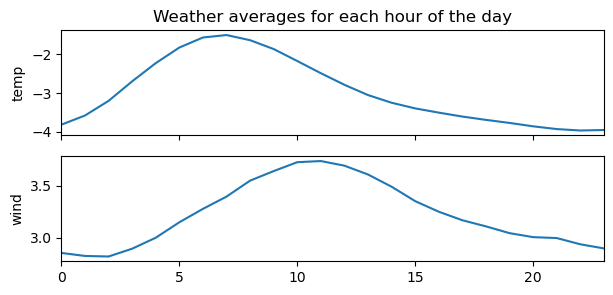

In [10]:
full_vars = []
for var in df.columns:
    if df[var].count() > 0 and var not in ['z','hour']:
        full_vars.append(var)
nvars = len(full_vars)
fig,axis = plt.subplots(nvars,1,figsize=(7,1.5*nvars),sharex=True)
df['hour'] = pd.to_datetime(df.index).hour

c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
c = next(c_iter)
for i,var in enumerate(full_vars):
    var_hourly = []
    for hour in np.arange(24):
        ds_hour = df[df['hour'] == hour]
        hourly_mean = np.mean(ds_hour[var])
        var_hourly.append(hourly_mean)
    axis[i].plot(np.arange(24),var_hourly)
    axis[i].set_ylabel(var)
    axis[i].set_xlim((0,23))
axis[0].set_title('Weather averages for each hour of the day')
plt.show()

In [11]:
df = df.drop(columns=['hour'])
df['z'] = np.ones(len(df.index)) * elev
df.to_csv(export_fp+export_fn)

In [ ]:
# ===== DONE! =====